In [2]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [9]:
# Load data 
data_AML = pd.read_csv('../TCGA_data/TCGA acute myeloid leukemia/TCGA.LAML.sampleMap_HiSeqV2', sep='\t', index_col=0)
data_breast = pd.read_csv('../TCGA_data/TCGA breast invasive carcinoma/TCGA.BRCA.sampleMap_HiSeqV2', sep='\t', index_col=0)
data_bladder = pd.read_csv('../TCGA_data/TCGA bladder urothelial carcinoma/TCGA.BLCA.sampleMap_HiSeqV2', sep='\t', index_col=0)
data_cervical = pd.read_csv('../TCGA_data/TCGA cervical squamous cell carcinoma and endocervical adenocarcinoma/TCGA.CESC.sampleMap_HiSeqV2', sep='\t', index_col=0)
data_adreno = pd.read_csv('../TCGA_data/TCGA adrenocortical carcinoma/TCGA.ACC.sampleMap_HiSeqV2', sep='\t', index_col=0)

datas = [data_AML, data_breast, data_bladder, data_cervical, data_adreno]
for data in datas:
    print(data.shape)

In [11]:
# Functions

# K-means algorithm
def distance(x, y):
    return np.sqrt(np.sum((x - y)**2))

def objective(data, means, clusters, K):
    objective = 0
    for k in range(K):
        for i in range(data.shape[0]):
            if clusters[i] == k:
                # Add the squared distance from X and its cluster's centroid to the objective
                objective += np.sum(distance(data[i],means[k])**2)
    return objective

def reestimate_means(data, clusters, K):
    means = np.zeros((K, data.shape[1]))
    for k in range(K):
        means[k] = np.mean(data[clusters == k], axis=0)
    return means

def kmeans(data, init_means, K, max_iter=100):
    # convert data from pd to np
    data = data.values
    means = []
    for i in range(K):
        means.append(init_means[i])
    means = np.array(means)
    clusters = np.zeros(data.shape[0])
    objective_values = []
    objective_values.append(objective(data, means, clusters, K))
    for i in range(max_iter):
        if i % 5 == 0:
            print("Iteration",i)
        # Assign each point to the closest mean
        for j in range(data.shape[0]):
            clusters[j] = np.argmin(np.sum((means - data[j])**2, axis=1))
        # Reestimate the means
        means = reestimate_means(data, clusters, K)
        # Compute the objective
        objective_values.append(objective(data, means, clusters, K))
        # Check for convergence
        if objective_values[-1] == objective_values[-2]:
            break
    return objective_values, clusters

def eigendecomp(df):
    ''' 
    eigendecomp takes a dataframe df and returns the eigenvalues and eigenvectors of the covariance matrix of df.
    '''
    # Centering
    df_centered = df - df.mean(axis=0)
    # Covariance matrix
    # S = np.cov(df_centered)
    S = np.dot(df_centered.T, df_centered) / (df_centered.shape[0] - 1) # QUES: why N-1 and not N?
    # Eigen decomposition
    eigvals, eigvecs = np.linalg.eigh(S)
    # Sort eigenvectors by eigenvalues in descending order
    idx = np.argsort(eigvals)[::-1]
    eigvals = eigvals[idx]
    eigvecs = eigvecs[:, idx]
    return eigvals, eigvecs

def project_data(df, eigvecs, n_components=2):
    ''' 
    project_data takes a dataframe df and eigenvectors and returns the projected data.
    '''
    # Centering
    df_centered = df - df.mean(axis=0)
    # Project data onto eigenvectors
    return np.dot(df_centered, eigvecs[:, :n_components])

In [13]:
# data preprocessing, subject to change
# converting to numpy as it may increase speed
# taking few genes to just check the clustering with them. Can take more later

data_AML_np = data_AML.to_numpy()
data_AML_np_fewgenes = data_AML_np[:1000, :]
data_breast_np = data_breast.to_numpy()
data_breast_np_fewgenes = data_breast_np[:1000, :]
data_bladder_np = data_bladder.to_numpy()
data_bladder_np_fewgenes = data_bladder_np[:1000, :]
data_cervical_np = data_cervical.to_numpy()
data_cervical_np_fewgenes = data_cervical_np[:1000, :]
data_adreno_np = data_adreno.to_numpy()
data_adreno_np_fewgenes = data_adreno_np[:1000, :]

In [61]:
# Perform K-means clustering on each cancertype

objective_values_list = []
clusters_list = []
for itr, dataframe_dealing_with in enumerate(datas):
    name = datas[itr]
    # choose 4 random datapoints for initial means
    random_cols = np.random.choice(dataframe_dealing_with.shape[1], size=4) # cols means samples here
    random_means = dataframe_dealing_with.values[:, random_cols]
    # Run the K-means algorithm
    objective_values, clusters = kmeans(dataframe_dealing_with.T, random_means.T, 4)
    objective_values_list.append(objective_values)
    clusters_list.append(clusters)

clusters_AML = clusters_list[0]
clusters_breast = clusters_list[1]
clusters_bladder = clusters_list[2]
clusters_cervical = clusters_list[3]
clusters_adreno = clusters_list[4]

Iteration 0
Iteration 5
Iteration 0
Iteration 5
Iteration 10
Iteration 15
Iteration 20
Iteration 0
Iteration 5
Iteration 10
Iteration 0
Iteration 0


In [18]:
# perform eigen decomposition on each cancertype

# doing transpose as that way one datapoint would be a sample and not a gene, which is what we want

eigvals_AML, eigvecs_AML = eigendecomp(data_AML_np_fewgenes.T)
eigvals_breast, eigvecs_breast = eigendecomp(data_breast_np_fewgenes.T)
eigvals_bladder, eigvecs_bladder = eigendecomp(data_bladder_np_fewgenes.T)
eigvals_cervical, eigvecs_cervical = eigendecomp(data_cervical_np_fewgenes.T)
eigvals_adreno, eigvecs_adreno = eigendecomp(data_adreno_np_fewgenes.T)

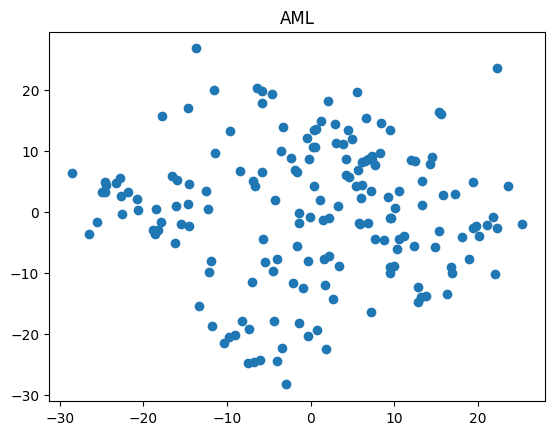

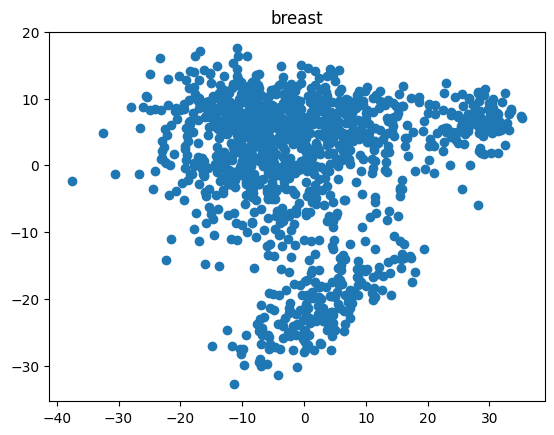

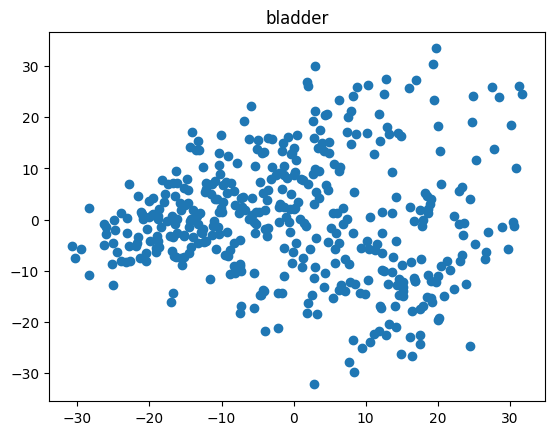

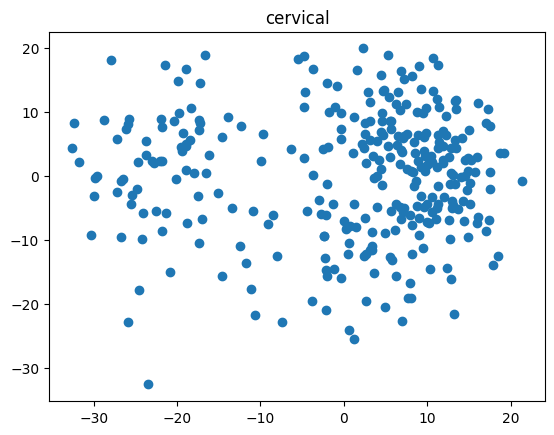

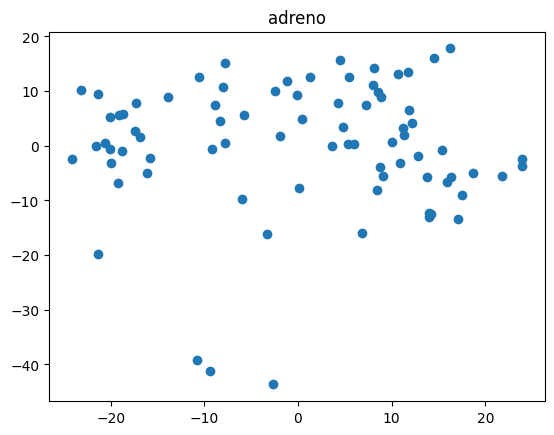

In [19]:
# plot scatterplot for each of the cancertype, without clustering visualization

## AML
data_AML_projected = project_data(data_AML_np_fewgenes.T, eigvecs_AML, n_components=2)
plt.scatter(data_AML_projected[:, 0], data_AML_projected[:, 1])
plt.title("AML")
plt.show()

## breast
data_breast_projected = project_data(data_breast_np_fewgenes.T, eigvecs_breast, n_components=2)
plt.scatter(data_breast_projected[:, 0], data_breast_projected[:, 1])
plt.title("breast")
plt.show()

## bladder
data_bladder_projected = project_data(data_bladder_np_fewgenes.T, eigvecs_bladder, n_components=2)
plt.scatter(data_bladder_projected[:, 0], data_bladder_projected[:, 1])
plt.title("bladder")
plt.show()

## cervical
data_cervical_projected = project_data(data_cervical_np_fewgenes.T, eigvecs_cervical, n_components=2)
plt.scatter(data_cervical_projected[:, 0], data_cervical_projected[:, 1])
plt.title("cervical")
plt.show()

## adreno
data_adreno_projected = project_data(data_adreno_np_fewgenes.T, eigvecs_adreno, n_components=2)
plt.scatter(data_adreno_projected[:, 0], data_adreno_projected[:, 1])
plt.title("adreno")
plt.show()

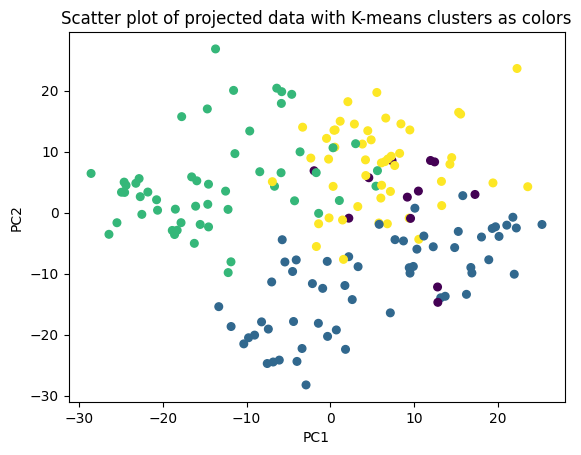

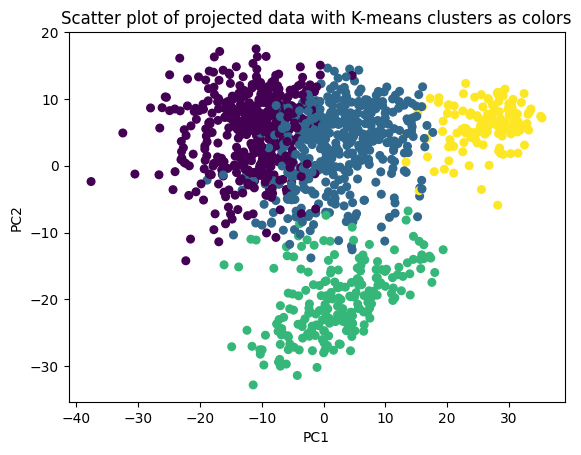

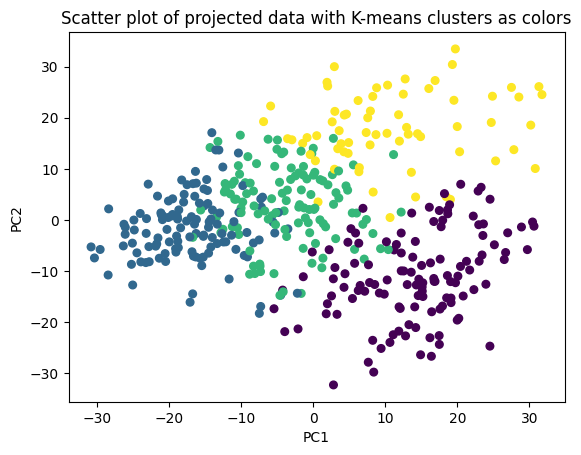

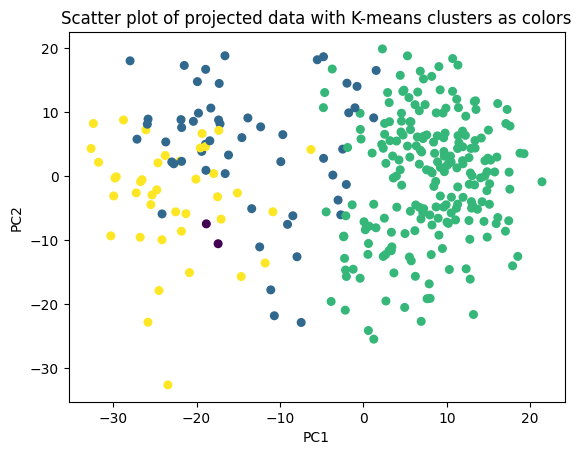

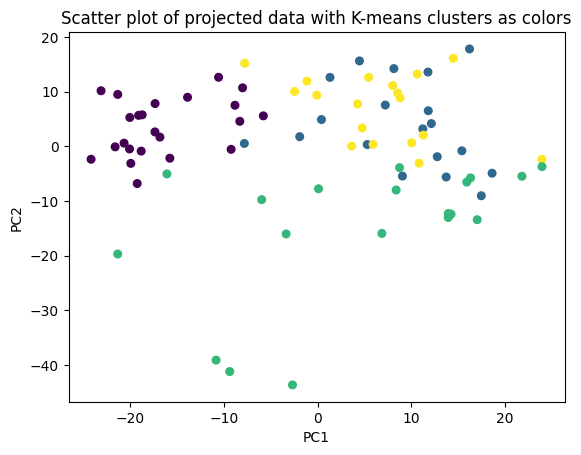

In [67]:
# Plot the reduced data with K-means clusters as colors for all cancertypes

## AML
plt.scatter(data_AML_projected[:, 0], data_AML_projected[:, 1], c=clusters_AML, s=30)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Scatter plot of projected data with K-means clusters as colors')
plt.show()

## breast
plt.scatter(data_breast_projected[:, 0], data_breast_projected[:, 1], c=clusters_breast, s=30)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Scatter plot of projected data with K-means clusters as colors')
plt.show()

## bladder
plt.scatter(data_bladder_projected[:, 0], data_bladder_projected[:, 1], c=clusters_bladder, s=30)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Scatter plot of projected data with K-means clusters as colors')
plt.show()

## cervical
plt.scatter(data_cervical_projected[:, 0], data_cervical_projected[:, 1], c=clusters_cervical, s=30)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Scatter plot of projected data with K-means clusters as colors')
plt.show()

## adreno
plt.scatter(data_adreno_projected[:, 0], data_adreno_projected[:, 1], c=clusters_adreno, s=30)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Scatter plot of projected data with K-means clusters as colors')
plt.show()

### Previous stuff

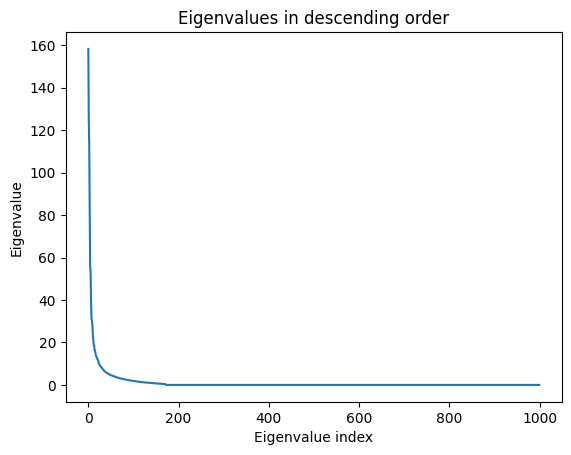

In [6]:
eigvals, eigvecs = eigendecomp(data_np_fewgenes.T) # data.T as one datapoint for us is not a gene but a sample (one of the 426)
plt.plot(eigvals)
plt.xlabel('Eigenvalue index')
plt.ylabel('Eigenvalue')
plt.title('Eigenvalues in descending order')
plt.show()

In [ ]:
# Run the K-means algorithm with k = 4
np.random.seed(0)
random_means = np.random.rand(4, data.shape[1])

# Run the K-means algorithm
objective_values, clusters = kmeans(data, random_means, 4)


# Plot the objective values
plt.plot(objective_values)
plt.xlabel('Iterations')
plt.ylabel('Objective')
plt.title('Objective value over iterations')
plt.show()


eigvals, eigvecs = eigendecomp(data)
plt.plot(eigvals)
plt.xlabel('Eigenvalue index')
plt.ylabel('Eigenvalue')
plt.title('Eigenvalues in descending order')
plt.show()

# print the first 2 eigenvalues/eigenvectors
print('The first two eigenvalues are:', eigvals[:2])
#print('The corresponding eigenvectors are:', eigvecs[:, :2])
# end solution

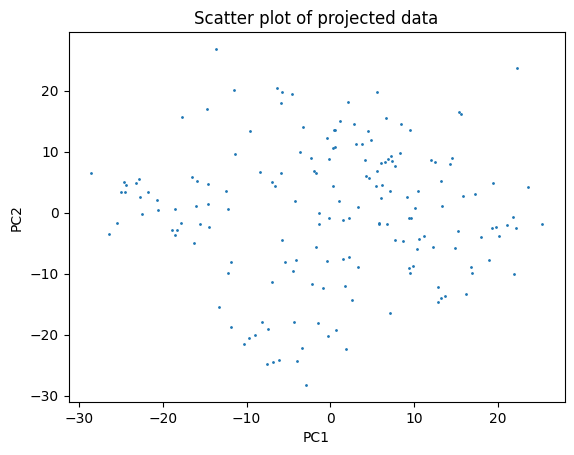

In [7]:
projected_data = project_data(data_np_fewgenes.T, eigvecs)
plt.scatter(projected_data[:, 0], projected_data[:, 1], s=1)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Scatter plot of projected data')
plt.show()

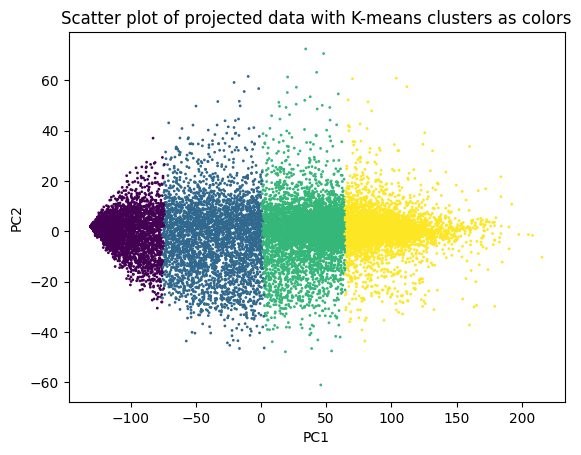

In [30]:
# Plot the reduced data with K-means clusters as colors
plt.scatter(projected_data[:, 0], projected_data[:, 1], c=clusters, s=1)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Scatter plot of projected data with K-means clusters as colors')
plt.show()

In [31]:
# Calculate the proportion of variance explained by each PC
variance_explained = eigvals / eigvals.sum()
# Find the number of PCs to capture at least 90% of the variance
n_components = np.argmax(np.cumsum(variance_explained) >= 0.95) + 1
print('Number of dimensions to reduce data to capture at least 95% of the variability:', n_components)

Number of dimensions to reduce data to capture at least 95% of the variability: 15


In [ ]:
''' 
I don't think this really has any purpose, I was just curious
'''
'''
data_np = data.values
# crop the data to the first 1000 genes
data_np_cropped = data_np[:1000]
# Plot the correlation coefficient matrix of the raw data
correlation_matrix = np.corrcoef(data_np_cropped)
plt.imshow(correlation_matrix, cmap='viridis')
plt.title('Correlation coefficient matrix of the raw data')
plt.show()

clusters_cropped = clusters[:1000]

# Sort the columns of the expression matrix according to the clusters found by K-means
grouped_data = np.empty((0, data_np_cropped.shape[1]))
for k in range(len(clusters)):
    if k % 1000 == 0:
        print("Sorting cluster", k)
    grouped_data = np.vstack((grouped_data, data_np_cropped[clusters_cropped == k])) 

# Plot the correlation coefficient matrix of the grouped data
correlation_matrix = np.corrcoef(grouped_data)
plt.imshow(correlation_matrix, cmap='viridis')
plt.title('Correlation coefficient matrix of the grouped data')
plt.show()
'''